This should have happened before:
```
muniphot *.fit
munimatch --verbose frame001.pht frame*.pht
munifind -a 2 found.txt match*
```

In [37]:
# CONFIG

basedir = './inputfiles/WWCrA/'
lightcurve_dir = basedir + "outstars/"
reference_frame = basedir+'WWCrA#30V_000409679_FLAT.fit'
aperture = 1

In [38]:
# IMPORT

import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns

from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.vo.client import conesearch
from astropy import units as u

In [48]:
def setup_wcs(coord, naxis1, naxis2):
    w = wcs.WCS(naxis=2)

    # Set up an "Airy's zenithal" projection
    # Vector properties may be set with Python lists, or Numpy arrays
    w.wcs.crpix = [naxis1/2.0, naxis2/2.0]
    w.wcs.cdelt = np.array([-0.000572222222222, 0.000572222222222])
    print("ra/dec", coord.ra.degree, coord.dec.degree)
    w.wcs.crval = [coord.ra.degree, coord.dec.degree]
    w.wcs.ctype = ["RA---AIR", "DEC--AIR"]
    return w
    
def pixel_to_radec(wcs_config, xpix, ypix):
    pixcrd = np.array([[xpix, ypix]], np.float_)
    result = wcs_config.wcs_pix2world(pixcrd, 1)
    return SkyCoord(result[0][0], result[0][1], unit='deg')

def star_to_radec():
    print("todo")
    
    
def get_fits_header(reference_file):
    hdulist = fits.open(reference_file)
    return hdulist[0].header




fits_header = get_fits_header(reference_frame)
object_ra = fits_header['OBJCTRA']
object_dec = fits_header['OBJCTDEC']
naxis1 = fits_header['NAXIS1']
naxis2 = fits_header['NAXIS2']
    
    
# coords of center of frame of first image
c = SkyCoord(object_ra, object_dec, unit="deg")
wcs_config = setup_wcs(c, naxis1, naxis2)
result = pixel_to_radec(wcs_config, 1365/2.0, 1365/2.0)
print(result)

ra/dec 18.09361111111111 -43.8325
<SkyCoord (ICRS): (ra, dec) in deg
    (18.09361111, -43.8325)>


In [30]:
#conesearch.list_catalogs()
my_catalog = 'Guide Star Catalog v2 1'
#c = SkyCoord.from_name('GSC 7911-3668')
result = conesearch.conesearch(c, 0.01 * u.degree, catalog_db=my_catalog)
print(result)


Trying http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&
   objID        gscID2    GSC1ID ... multipleFlag compassGSC2id    Mag   
                                 ...                               mag   
------------ ------------ ------ ... ------------ ------------- ---------
203233002289 S03233002289        ...            0 3659200002289   19.9072
203233002328 S03233002328        ...            0 3659200002328 19.318199


In [31]:
# Set the WCS information manually by setting properties of the WCS
# object.

# Create a new WCS object.  The number of axes must be set
# from the start
w = wcs.WCS(naxis=2)

# Set up an "Airy's zenithal" projection
# Vector properties may be set with Python lists, or Numpy arrays
w.wcs.crpix = [1365/2.0, 1365/2.0]
w.wcs.cdelt = np.array([-0.000572222222222, 0.000572222222222])
w.wcs.crval = [18.0936111, -43.8325000]
w.wcs.ctype = ["RA---AIR", "DEC--AIR"]

# Some pixel coordinates of interest.
pixcrd = np.array([[0, 0], [1365/2.0, 1365/2.0], [45, 98]], np.float_)

# Convert pixel coordinates to world coordinates
world = w.wcs_pix2world(pixcrd, 1)
print(world)

# Convert the same coordinates back to pixel coordinates.
pixcrd2 = w.wcs_world2pix(world, 1)
print(pixcrd2)

# These should be the same as the original pixel coordinates, modulo
# some floating-point error.
assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6

# Now, write out the WCS object as a FITS header
header = w.to_header()

# header is an astropy.io.fits.Header object.  We can use it to create a new
# PrimaryHDU and write it to a file.
hdu = fits.PrimaryHDU(header=header)
# Save to FITS file
# hdu.writeto('test.fits')

[[ 18.63856748 -44.22175161]
 [ 18.0936111  -43.8325    ]
 [ 18.60215434 -44.16583993]]
[[ -4.76461537e-10  -4.68389771e-10]
 [  6.82500000e+02   6.82500000e+02]
 [  4.50000000e+01   9.80000000e+01]]


Read the Munifind file to get STDEV of all stars

In [32]:

# INDEX MEAN_MAG STDEV GOODPOINTS
def read_munifind(filename):
    df = pd.read_csv(filename, skiprows=[1], sep=' ')
    df.rename(columns = {'INDEX':'STAR'}, inplace = True)
    print("max goodpoints:", df['GOODPOINTS'].max())
    print("min stdev:", df['STDEV'].min())
    print(df.sort_values('STDEV').head())
    return df

df = read_munifind(basedir+'found.txt')


max goodpoints: 81
min stdev: 0.00453
     STAR  MEAN_MAG    STDEV  GOODPOINTS
57     69   0.59902  0.00453          81
143   166   1.49768  0.00561          77
159   180   1.60704  0.00685          81
37     46   0.24022  0.00690          81
108   123   1.20015  0.00695          80


index 2675 is <pandas.core.indexing._iLocIndexer object at 0x7f4681d05198>


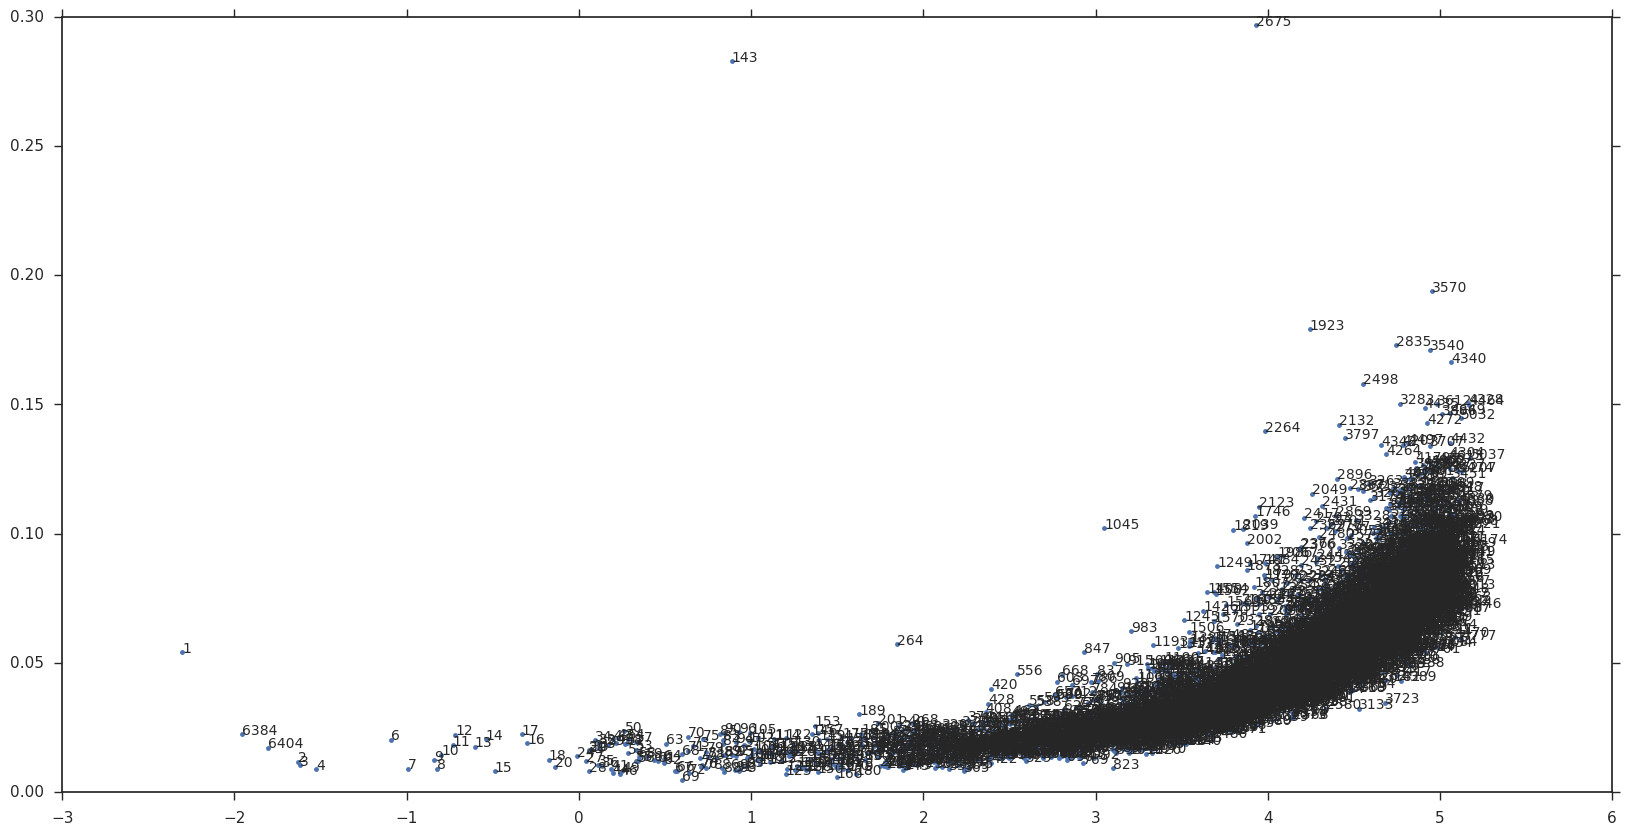

In [33]:
%matplotlib inline
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
x = df['MEAN_MAG']
y = df['STDEV']
z = df['GOODPOINTS']
realx = x
realy = y
ax.plot(realx, realy, '.')
for i, d in enumerate(x):
    ax.annotate(df['STAR'][i], (realx[i],realy[i]))
print('index 2675 is', df.iloc(2675))


In [58]:
def getBestComparisonStars():
    result = []
    # TODO: filter all stars which have not the maximum of GOODPOINTS
    lowest_stdev = df.sort_values('STDEV')
#    print(lowest_stdev.describe())
    for entry in range(0,10):
        #print(lowest_stdev.iloc[[entry]].index[0])
        #print(lowest_stdev.iloc[[entry]].values[0])
        print(lowest_stdev.iloc[[entry]])
        result.append((lowest_stdev.iloc[[entry]].index[0], lowest_stdev.iloc[[entry]]['GOODPOINTS']))
    return result
        
    
bestcomps = getBestComparisonStars()
check_stars = []
for star in bestcomps:
    print(star)
    check_stars.append(star['STAR'])
check_stars_str = ','.join(map(str, check_stars)) 
print(check_stars_str)

    STAR  MEAN_MAG    STDEV  GOODPOINTS
57    69   0.59902  0.00453          81
     STAR  MEAN_MAG    STDEV  GOODPOINTS
143   166   1.49768  0.00561          77
     STAR  MEAN_MAG    STDEV  GOODPOINTS
159   180   1.60704  0.00685          81
    STAR  MEAN_MAG   STDEV  GOODPOINTS
37    46   0.24022  0.0069          81
     STAR  MEAN_MAG    STDEV  GOODPOINTS
108   123   1.20015  0.00695          80
    STAR  MEAN_MAG    STDEV  GOODPOINTS
33    44    0.1964  0.00716          78
    STAR  MEAN_MAG    STDEV  GOODPOINTS
61    72   0.63893  0.00723          79
     STAR  MEAN_MAG    STDEV  GOODPOINTS
130   150    1.3863  0.00773          81
    STAR  MEAN_MAG    STDEV  GOODPOINTS
75    88   0.84183  0.00783          81
     STAR  MEAN_MAG    STDEV  GOODPOINTS
320   365   2.23651  0.00792          81
(57, 57    81
Name: GOODPOINTS, dtype: int64)


TypeError: tuple indices must be integers or slices, not str

In [9]:
print(df.iloc(143))

In [10]:
range(1,1000)

range(1, 1000)

In [43]:
import subprocess
# munilist -a 2 --object 143 -v 143 -c 40 143.txt match*.pht

def write_lightcurve(checkstar, star_list, aperture, lightcurve_dir):
    !mkdir {lightcurve_dir}
    for star in star_list:
        !munilist -a {str(aperture)} --object {str(star)} -v {str(star)} -c {str(checkstar)} {lightcurve_dir + str(star) + ".txt"} {basedir+'match*.pht'}

def write_pos(star_list, aperture, lightcurve_dir):
    !mkdir {lightcurve_dir}
    for star in star_list:
        !munilist -a {str(aperture)} --obj-plot --object {str(star)} {lightcurve_dir + "pos_" + str(star) + ".txt"} {basedir+'match*.pht'}
                
#star_list = (143,264,2675,1045,847,1193)
star_list = range(1,100)
write_pos(star_list, aperture, lightcurve_dir)
write_lightcurve(49, star_list, aperture, lightcurve_dir)

mkdir: cannot create directory ‘./inputfiles/WWCrA/outstars/’: File exists
munilist (cmunipack) version 2.1.14

./inputfiles/WWCrA/match001.pht
./inputfiles/WWCrA/match002.pht
./inputfiles/WWCrA/match003.pht
./inputfiles/WWCrA/match004.pht
./inputfiles/WWCrA/match005.pht
./inputfiles/WWCrA/match006.pht
./inputfiles/WWCrA/match007.pht
./inputfiles/WWCrA/match008.pht
./inputfiles/WWCrA/match009.pht
./inputfiles/WWCrA/match010.pht
./inputfiles/WWCrA/match011.pht
./inputfiles/WWCrA/match012.pht
./inputfiles/WWCrA/match013.pht
./inputfiles/WWCrA/match014.pht
./inputfiles/WWCrA/match015.pht
./inputfiles/WWCrA/match016.pht
./inputfiles/WWCrA/match017.pht
./inputfiles/WWCrA/match018.pht
./inputfiles/WWCrA/match019.pht
./inputfiles/WWCrA/match020.pht
./inputfiles/WWCrA/match021.pht
./inputfiles/WWCrA/match022.pht
./inputfiles/WWCrA/match023.pht
./inputfiles/WWCrA/match024.pht
./inputfiles/WWCrA/match025.pht
./inputfiles/WWCrA/match026.pht
./inputfiles/WWCrA/match027.pht
./inputfiles/WWCrA/match

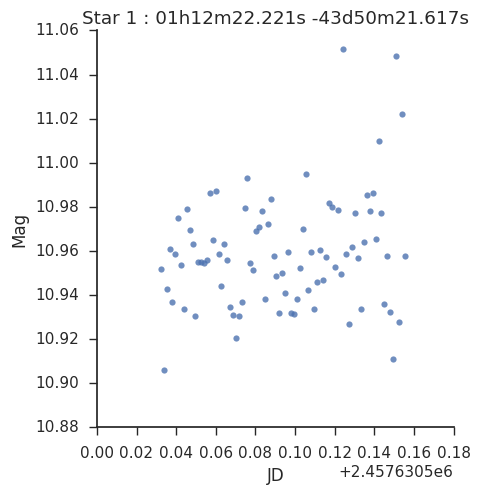

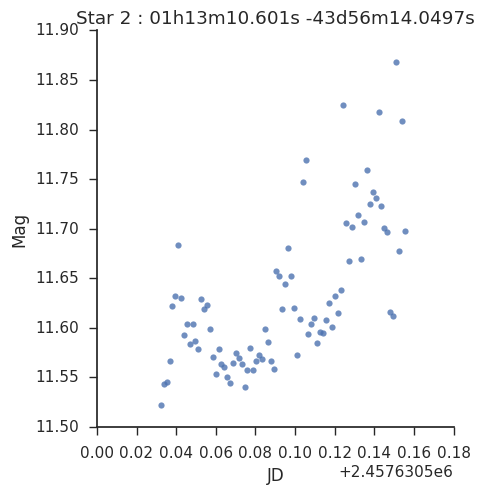

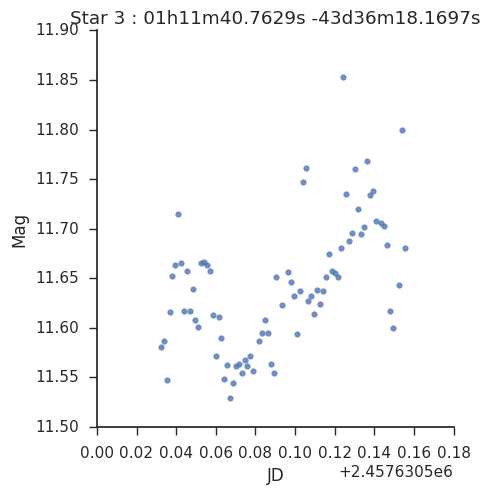

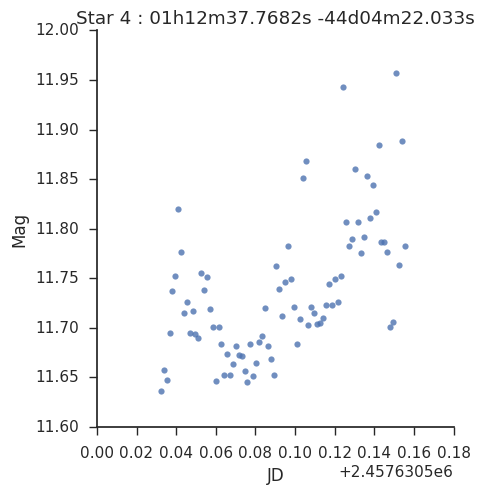

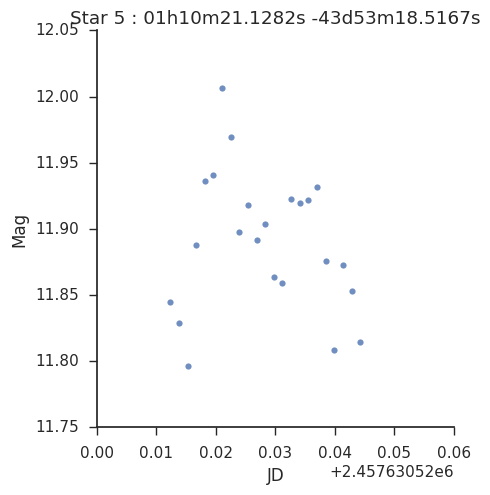

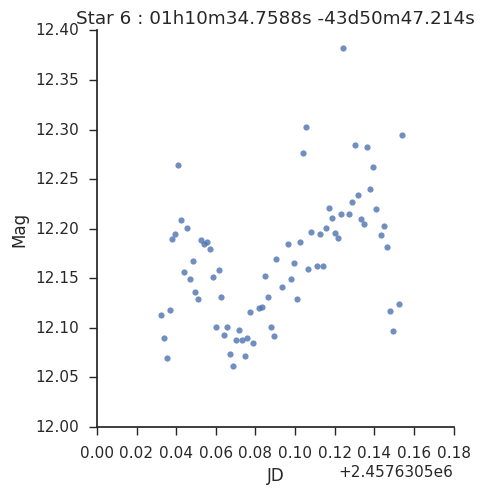

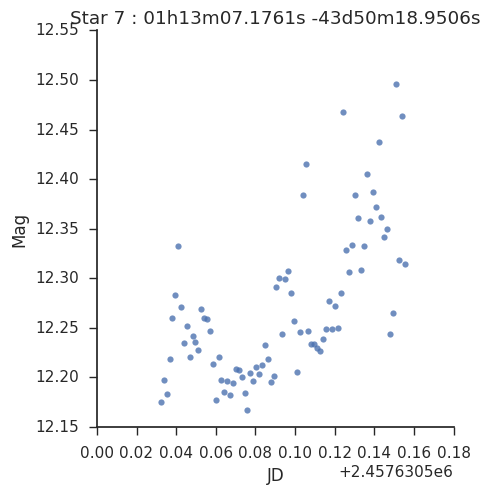

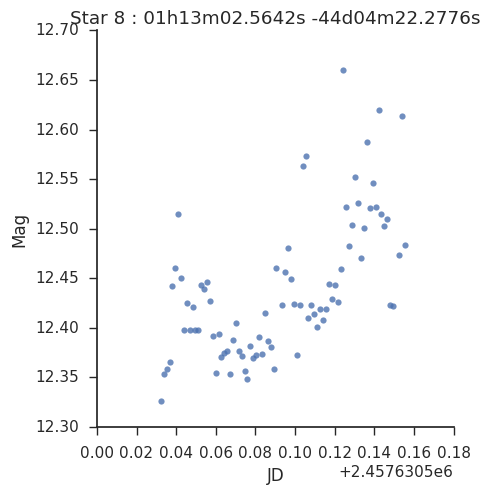

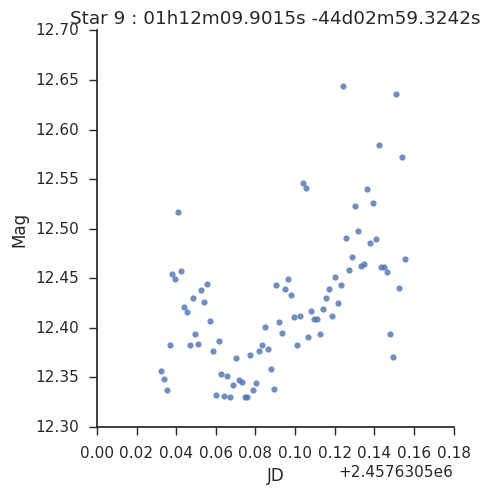

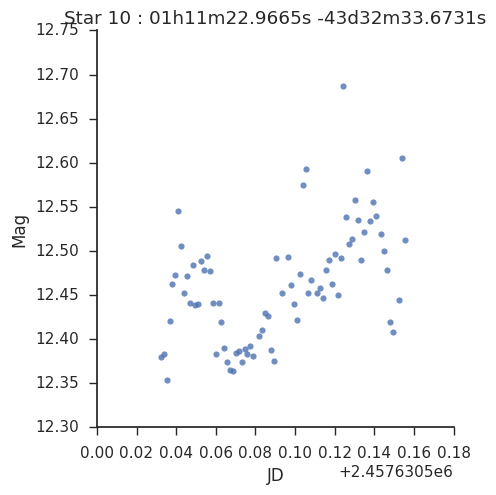

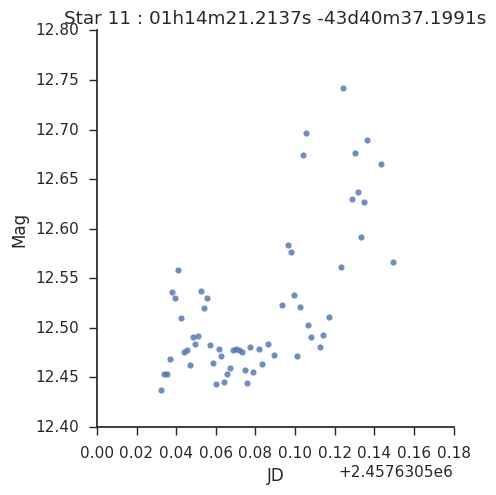

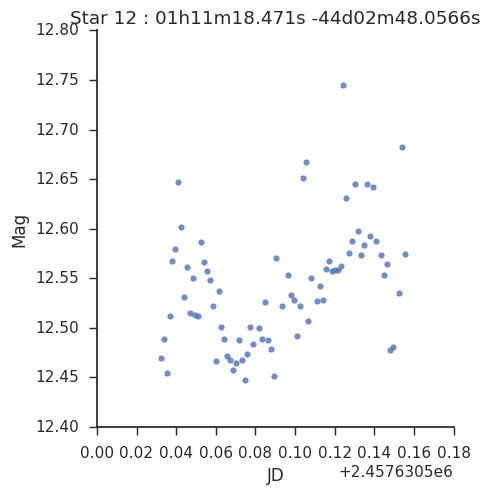

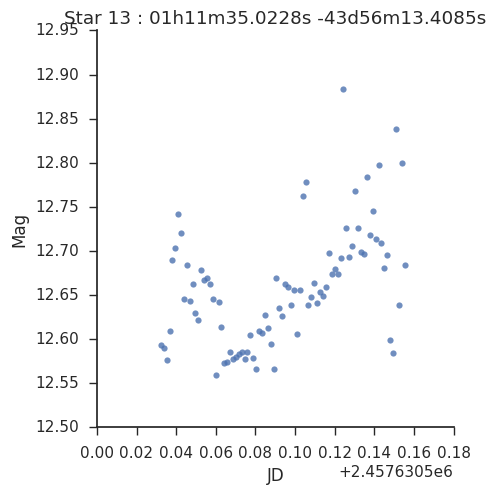

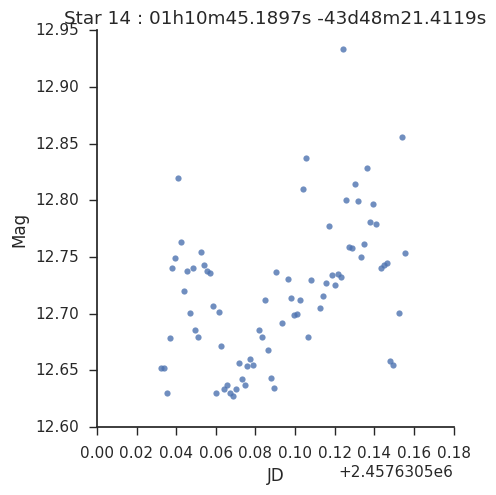

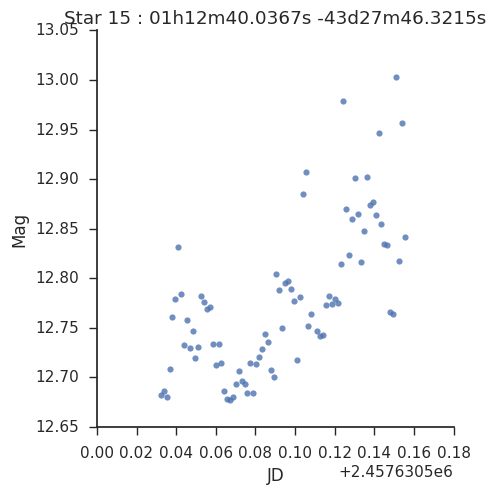

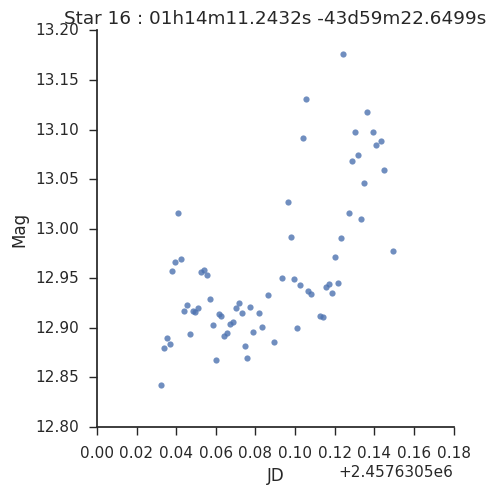

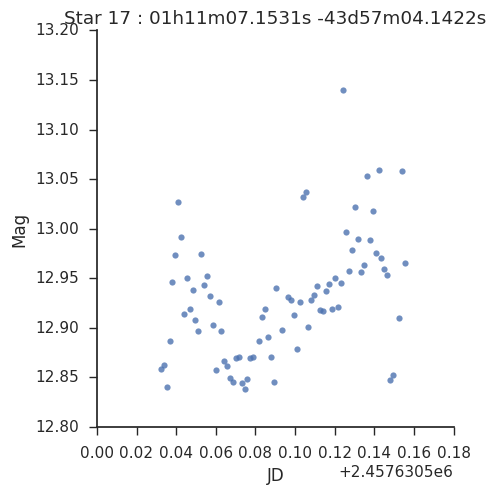

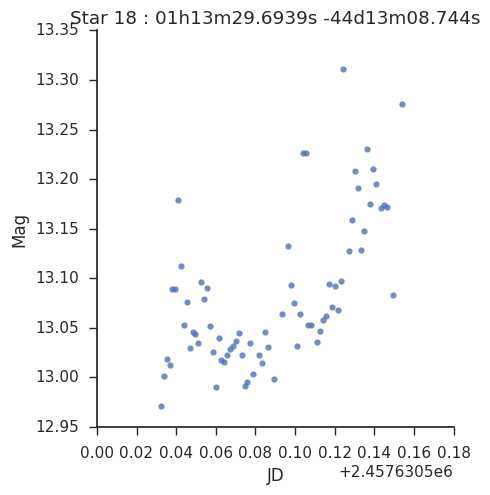

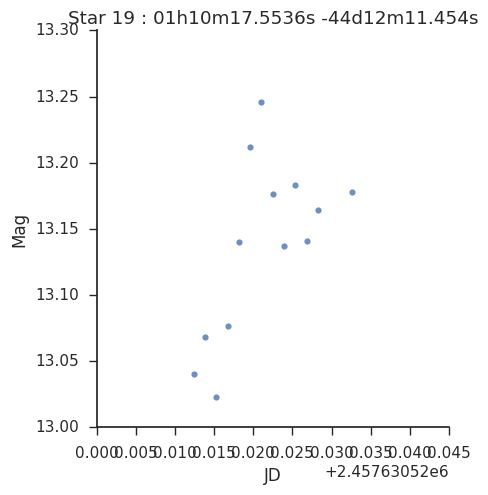

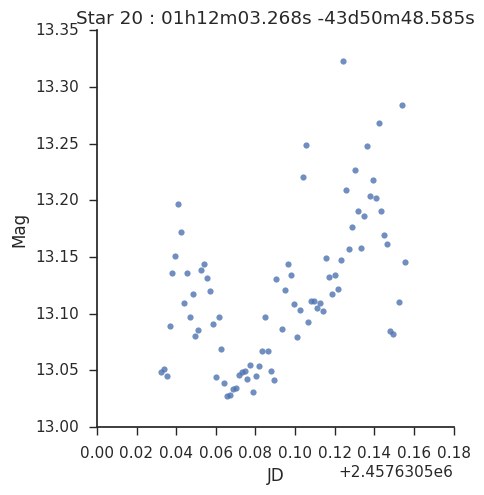

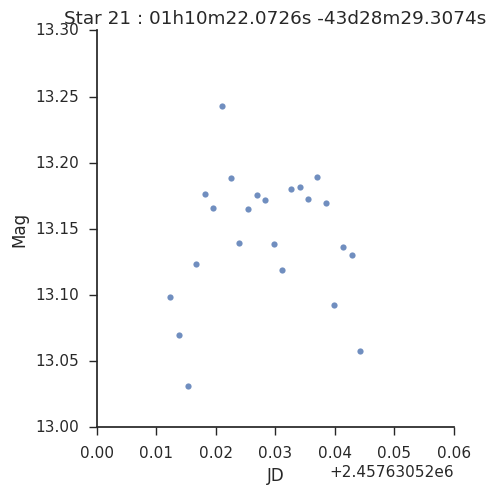

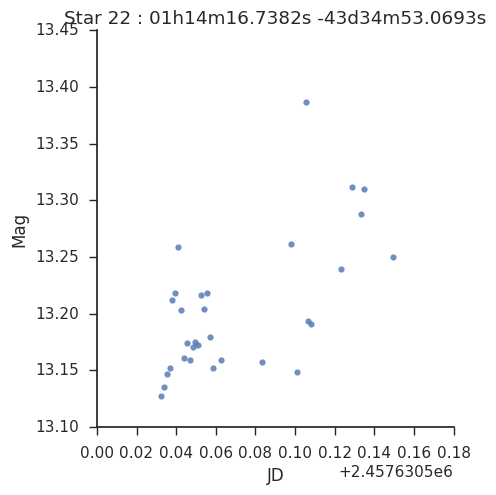

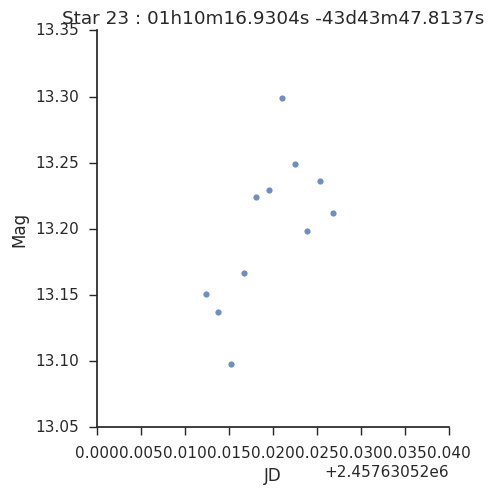

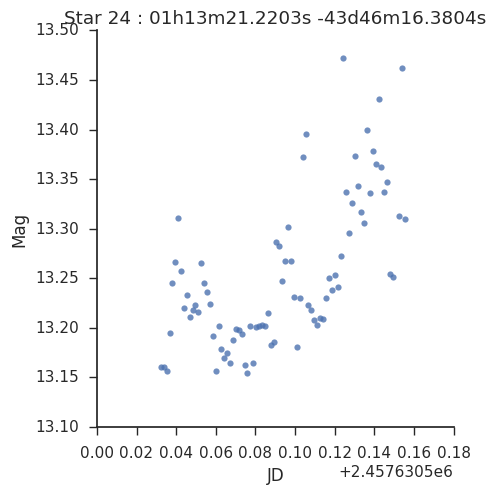

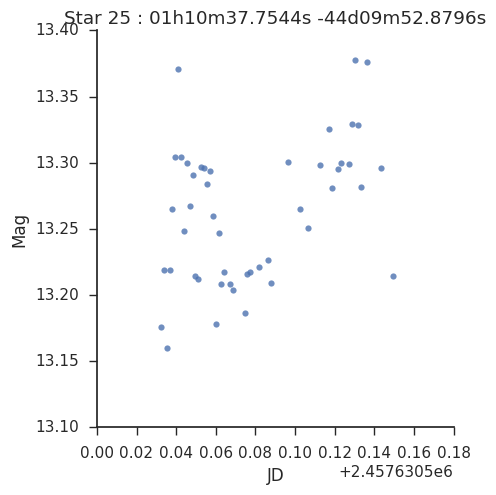

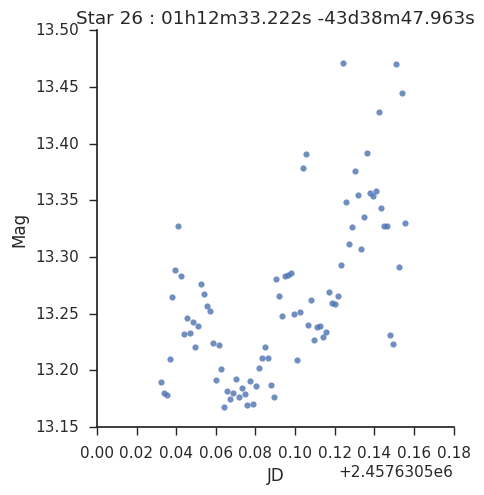

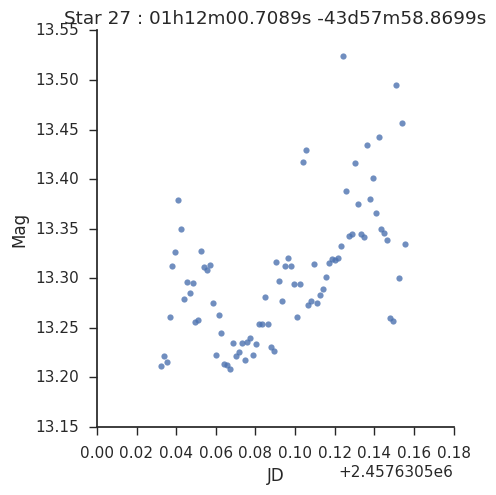

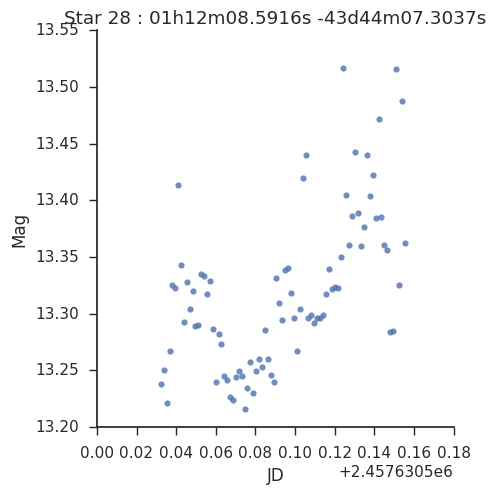

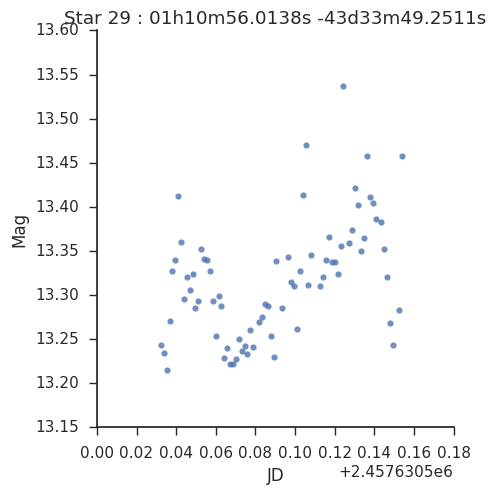

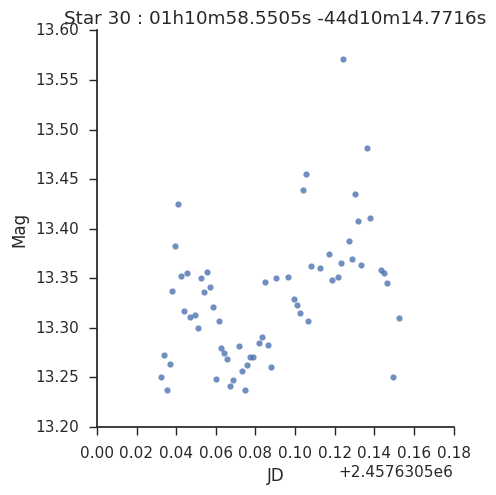

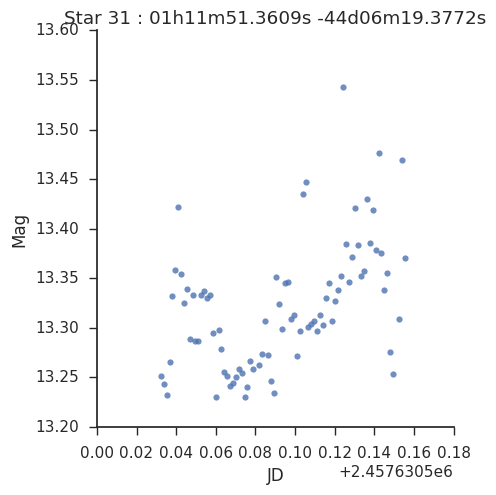

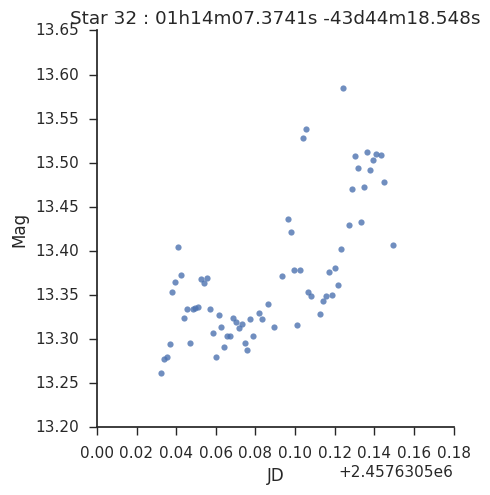

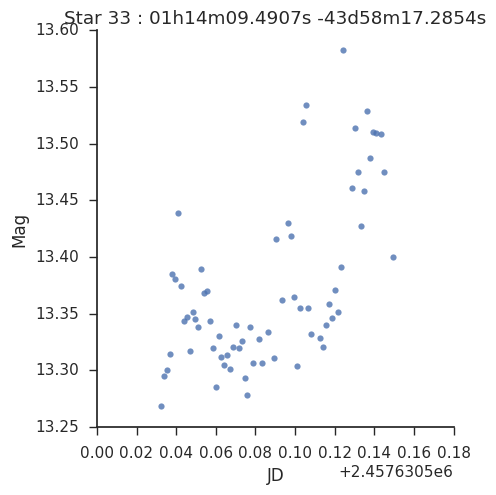

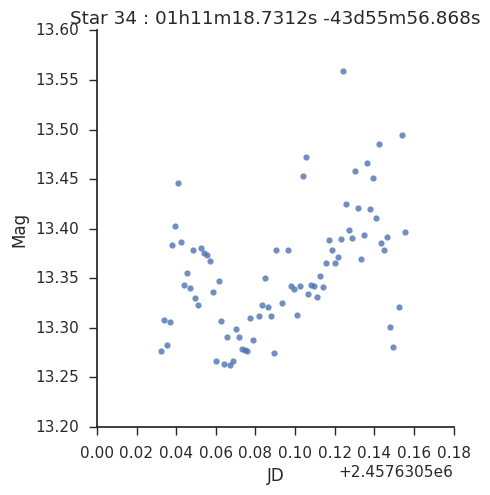

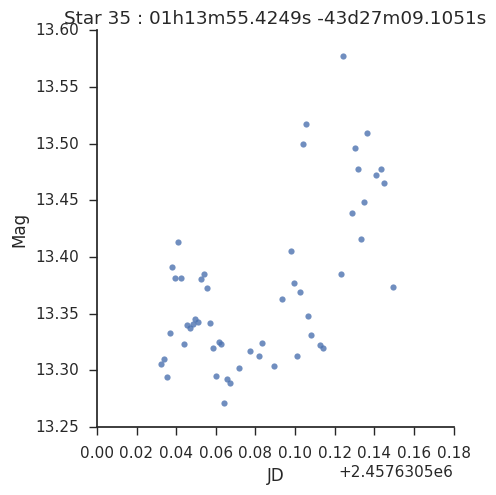

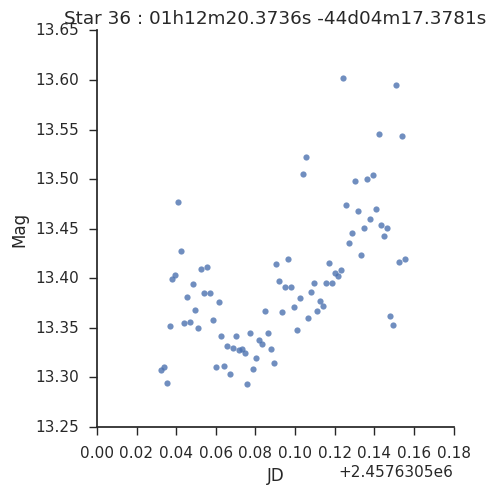

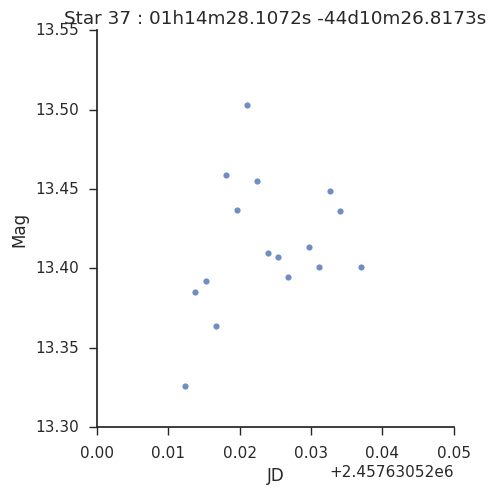

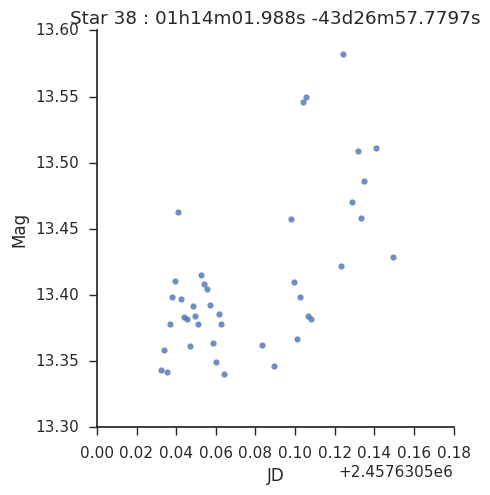

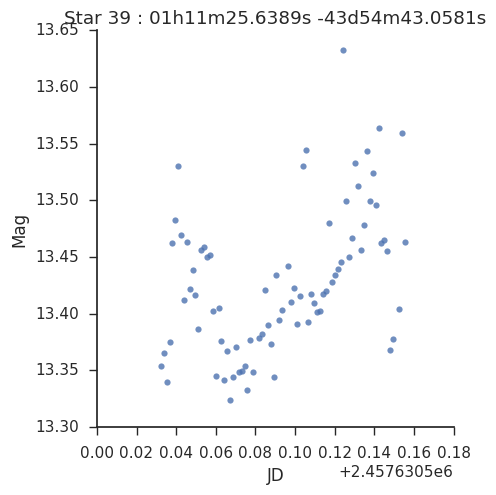

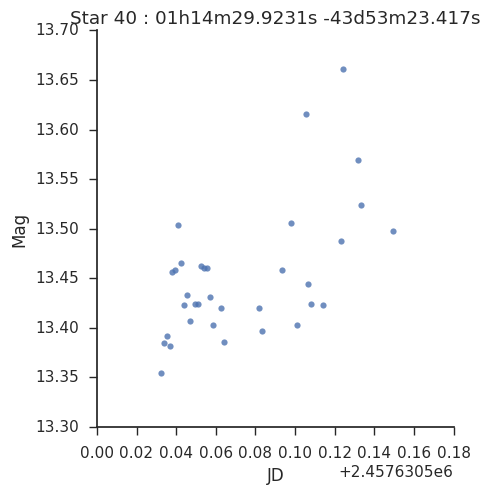

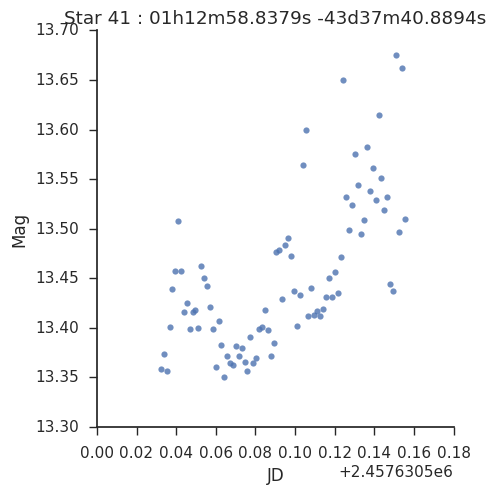

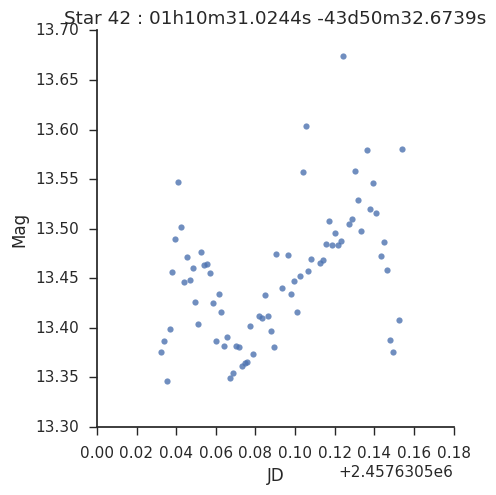

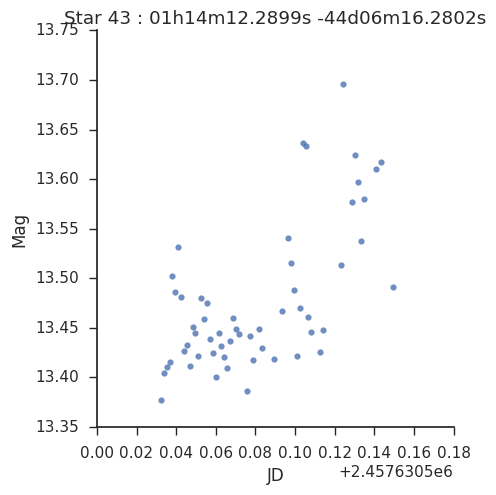

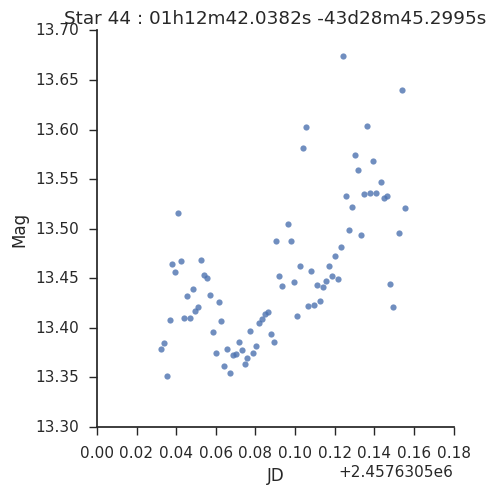

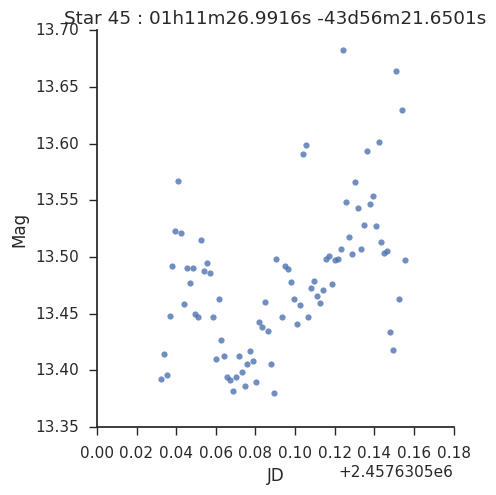

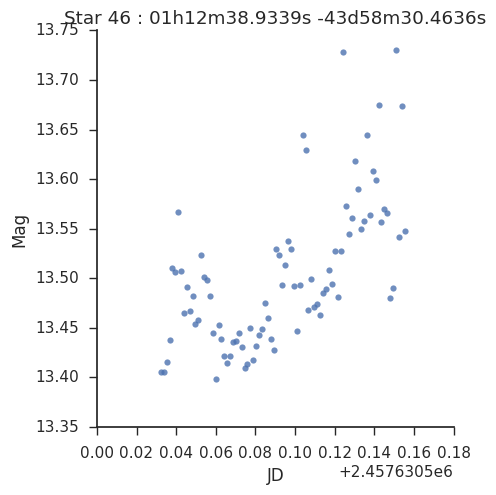

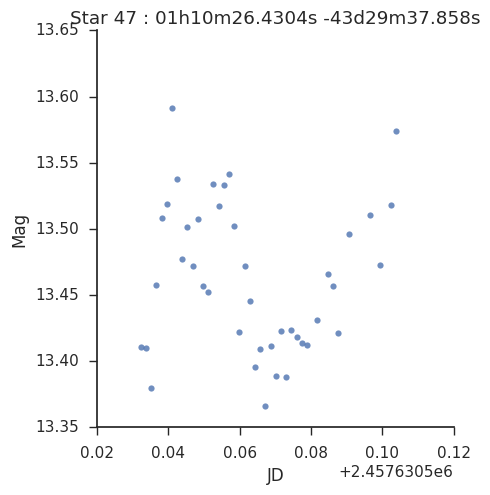

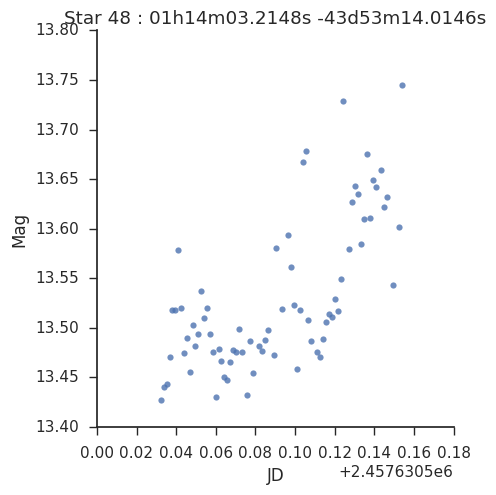

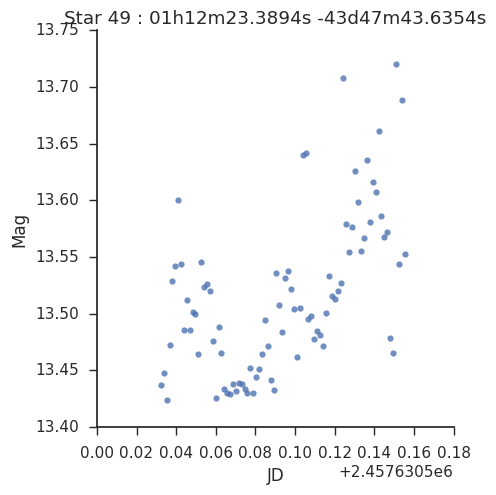

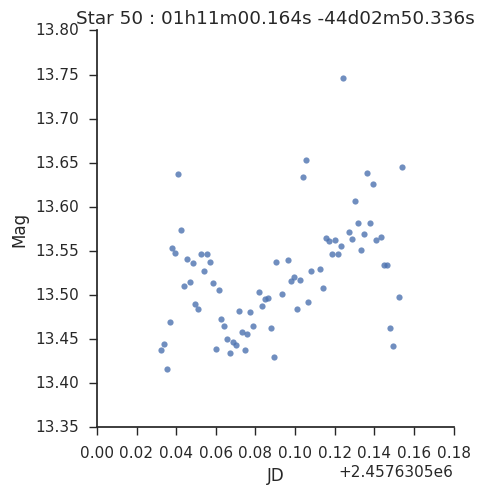

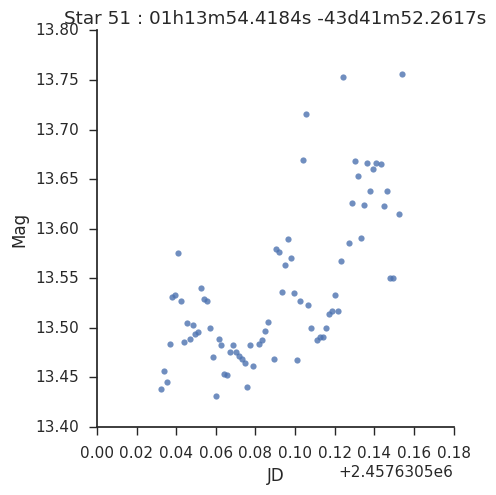

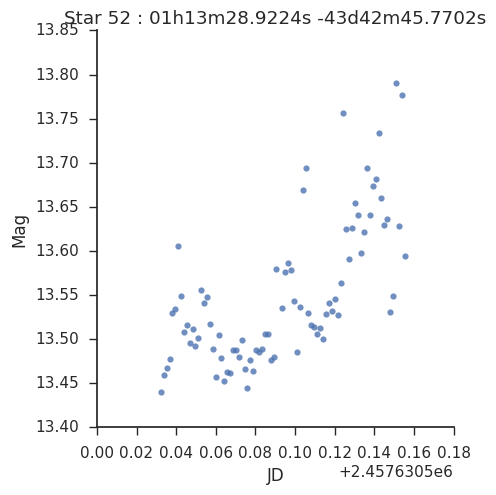

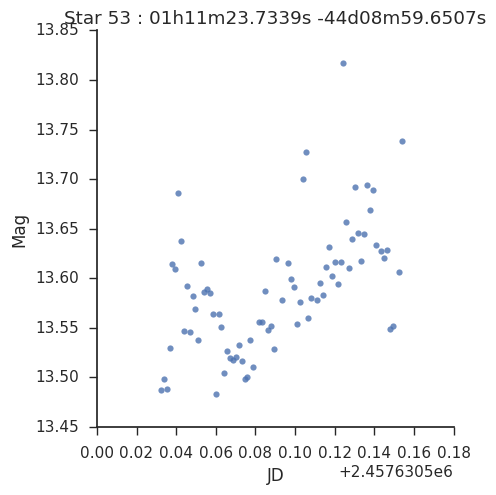

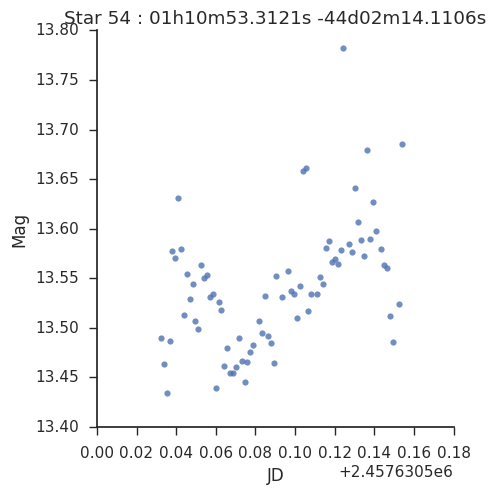

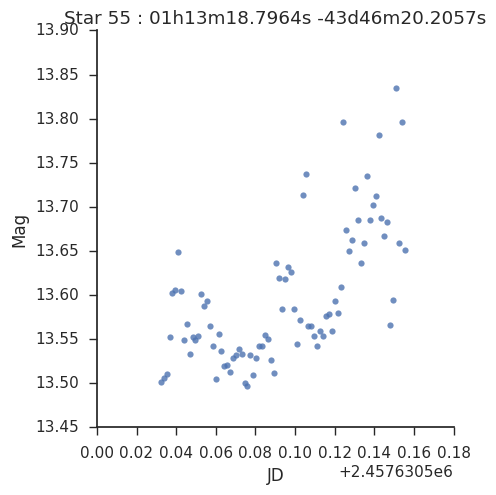

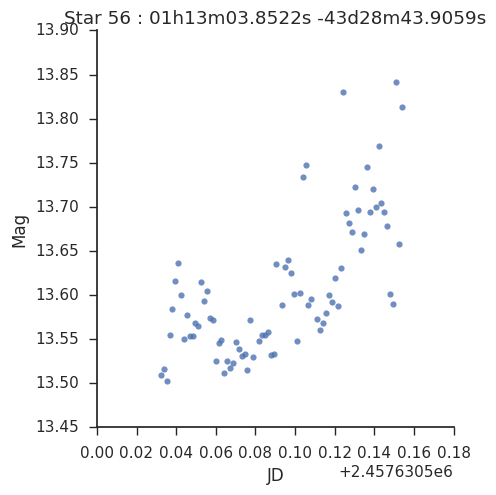

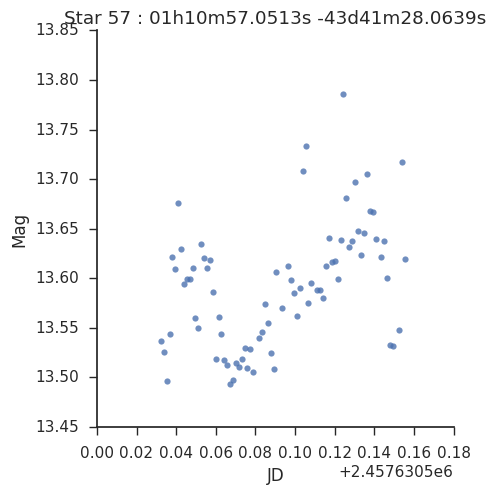

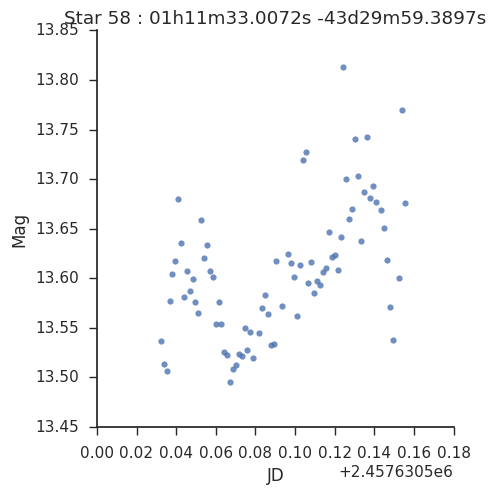

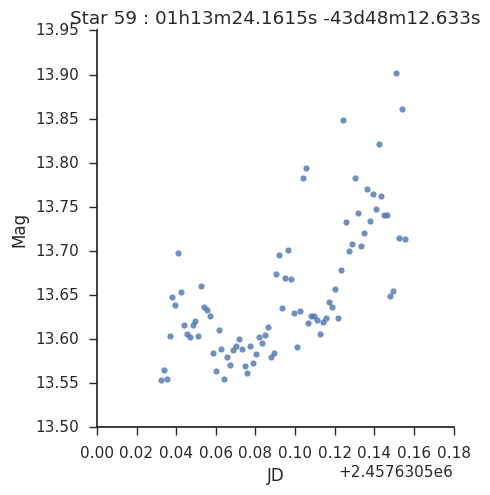

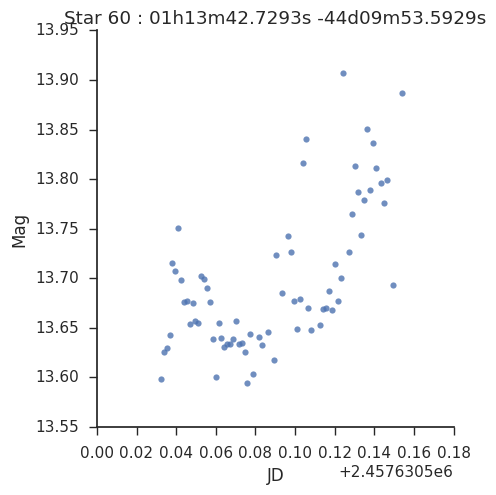

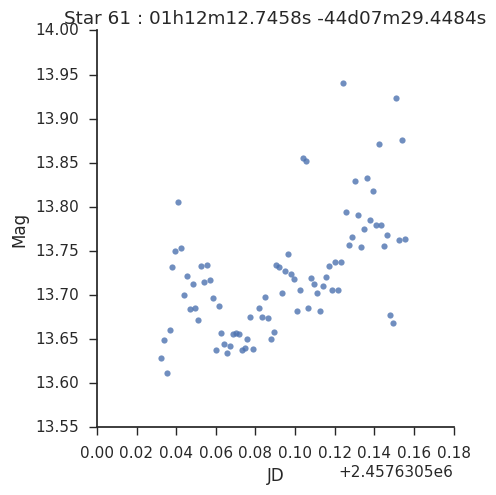

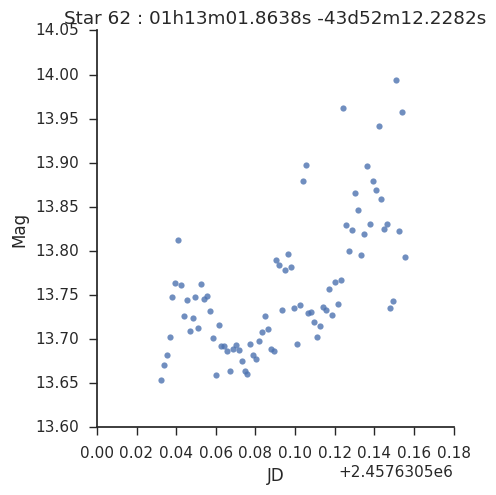

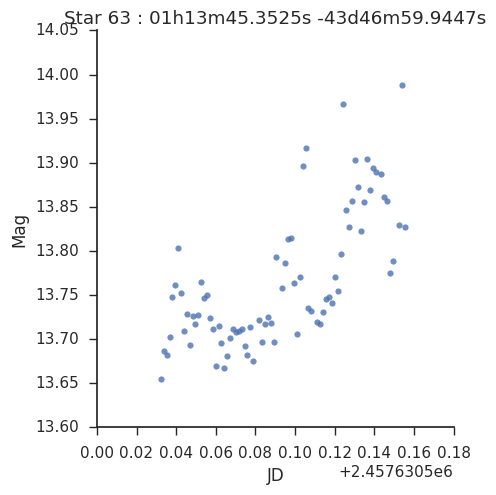

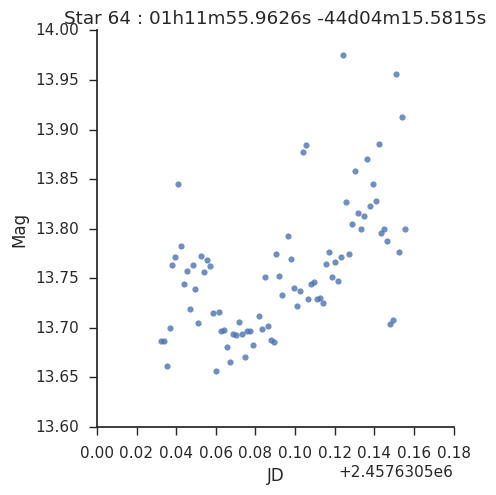

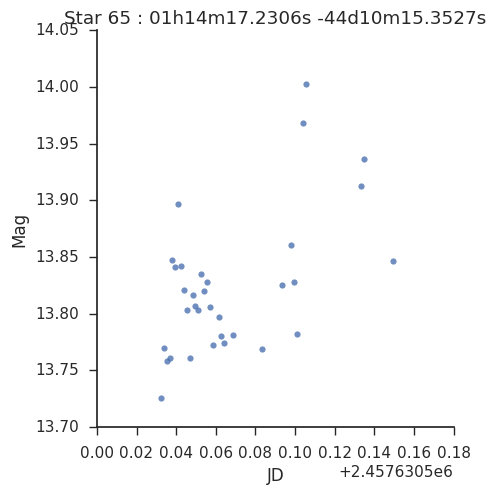

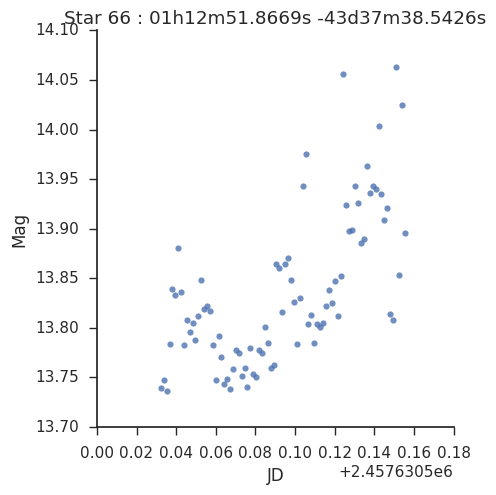

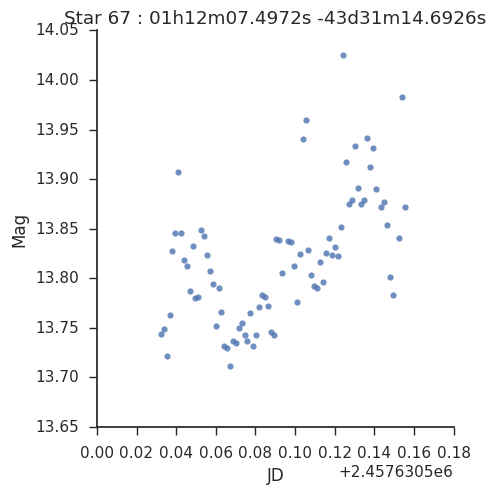

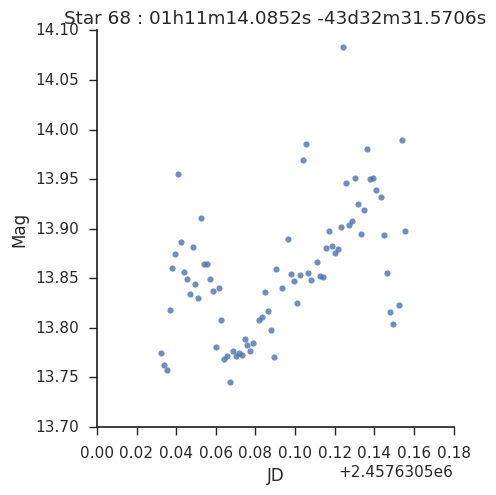

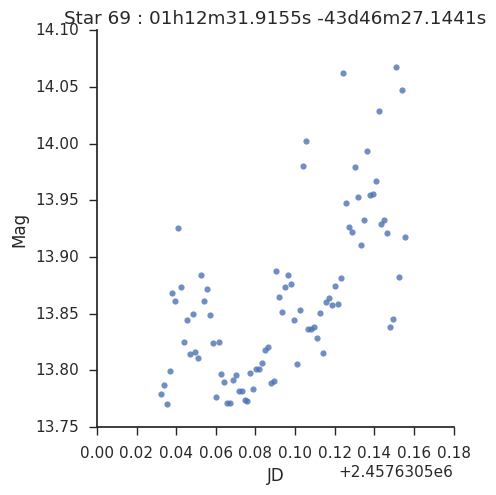

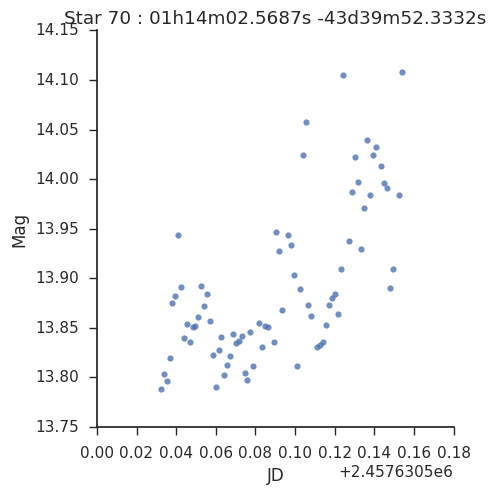

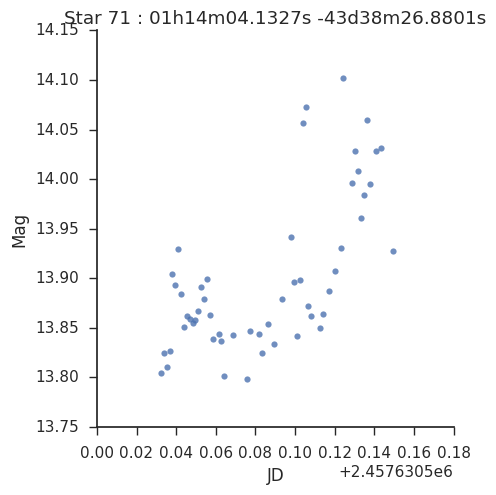

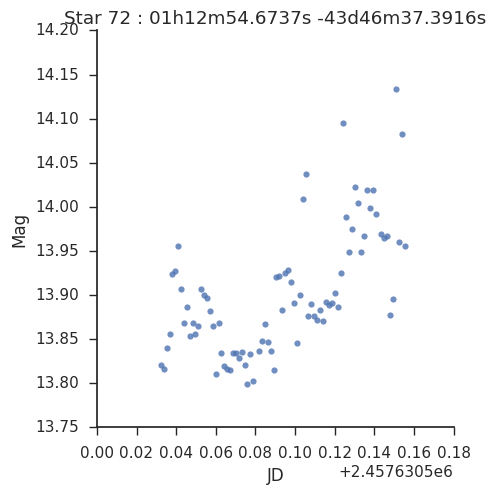

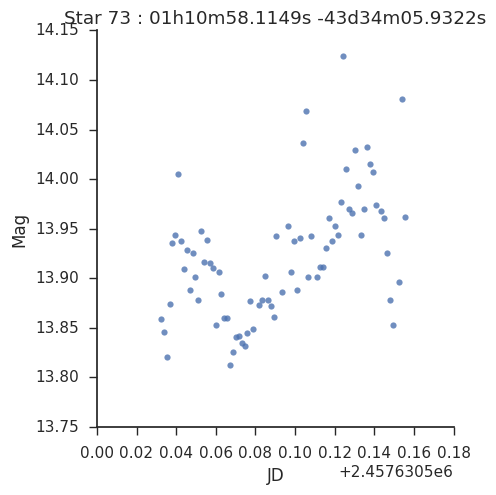

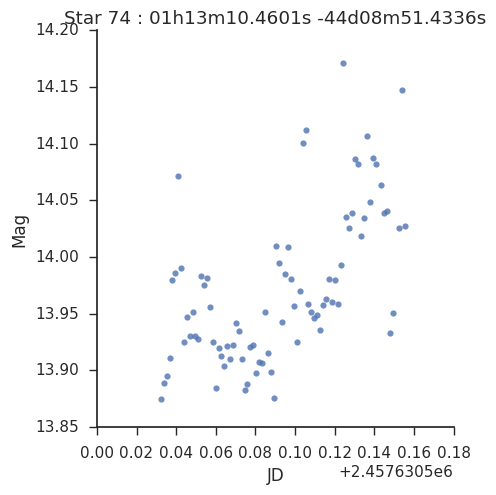

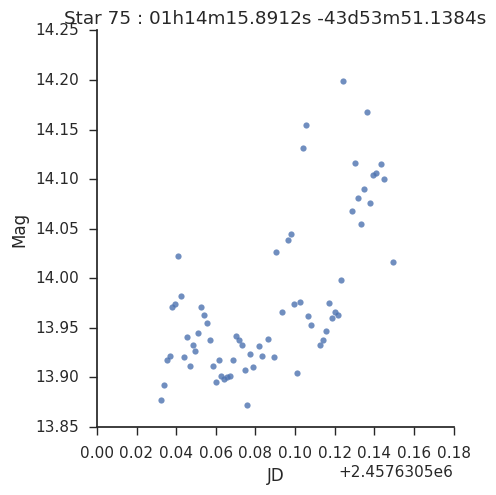

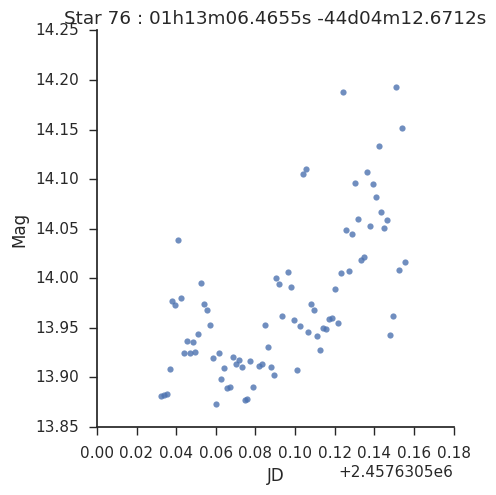

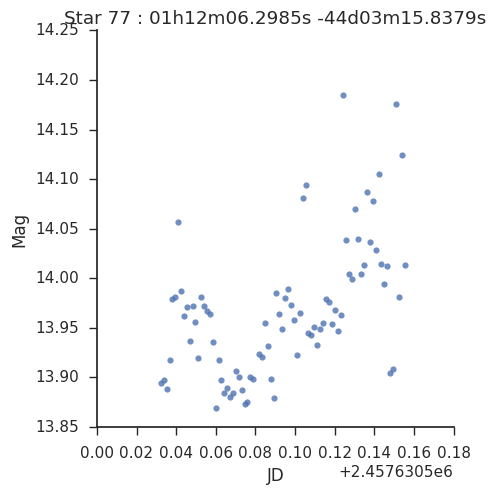

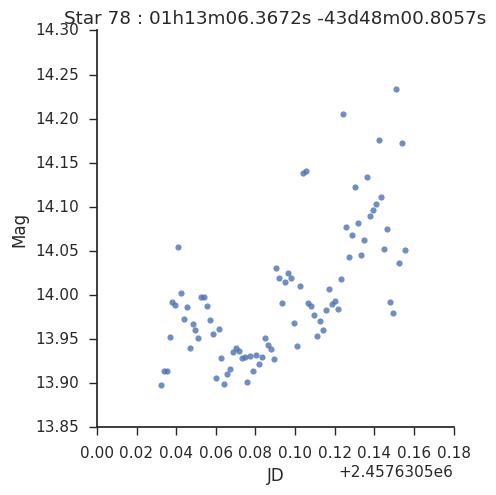

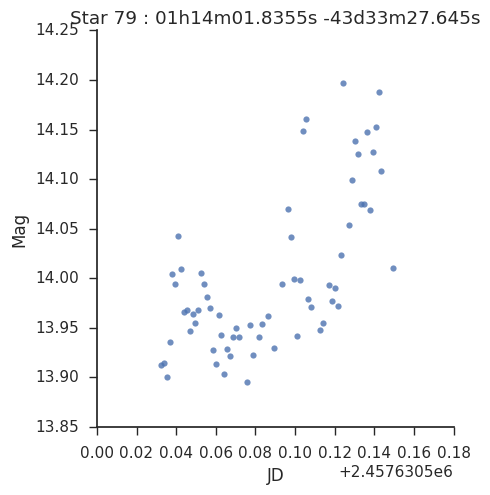

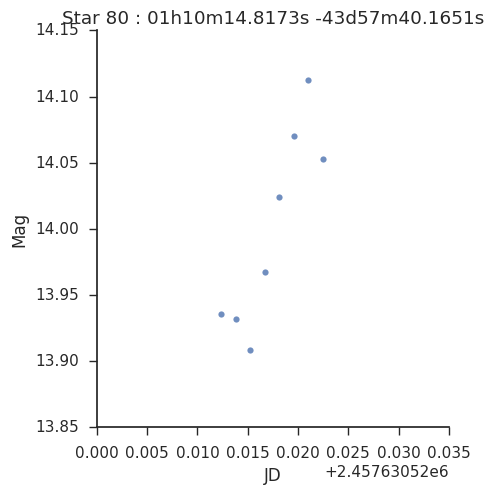

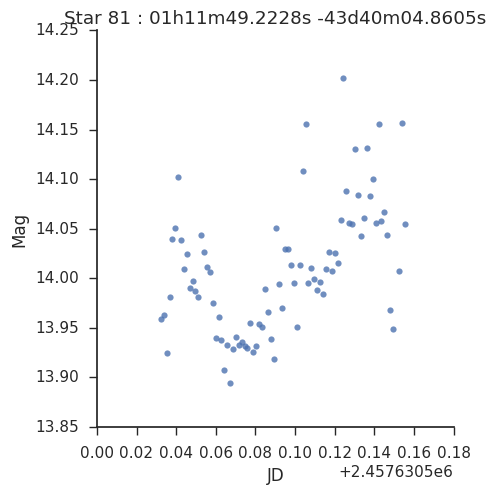

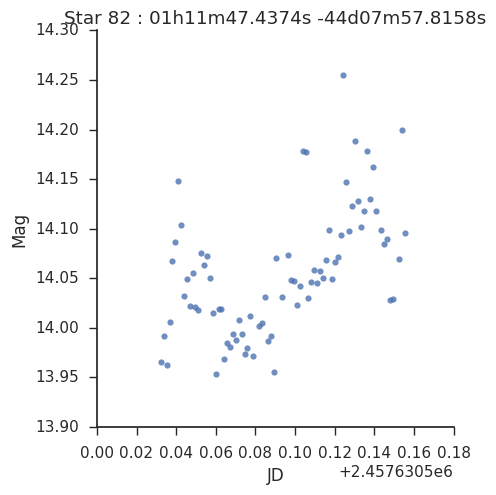

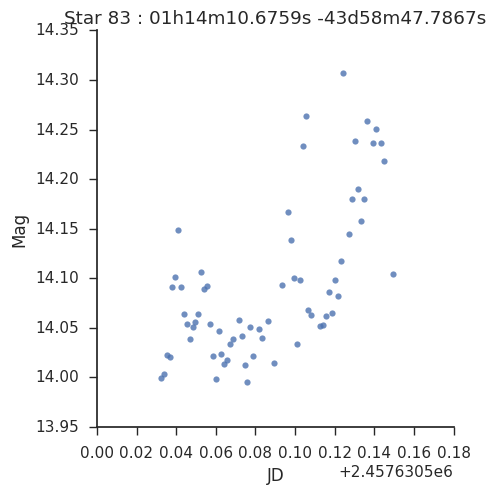

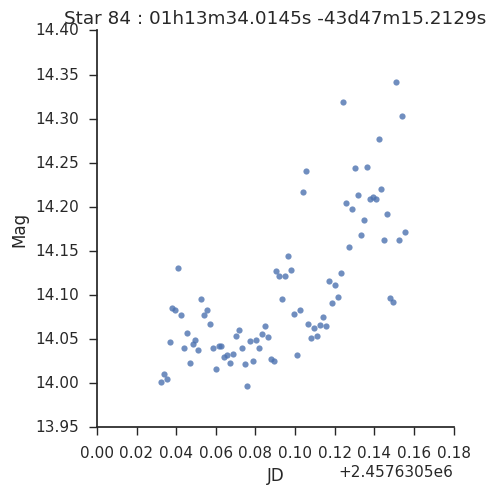

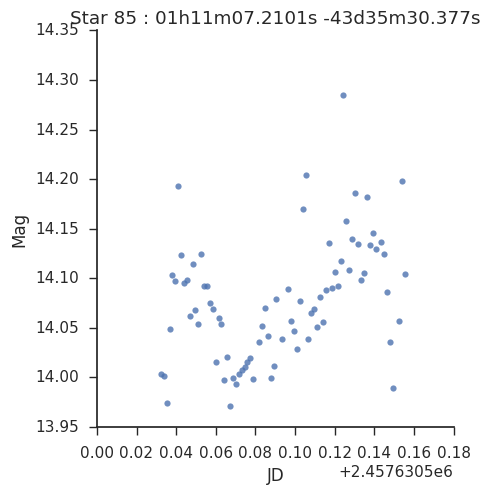

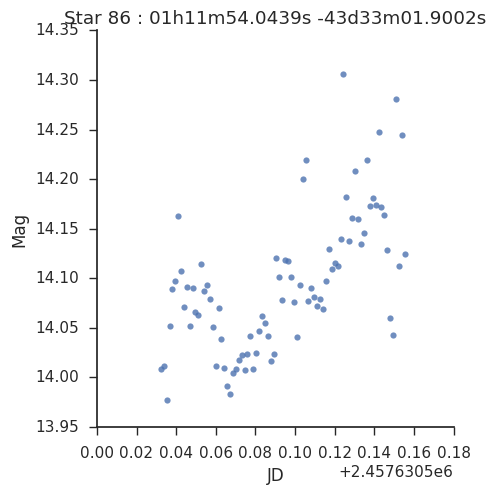

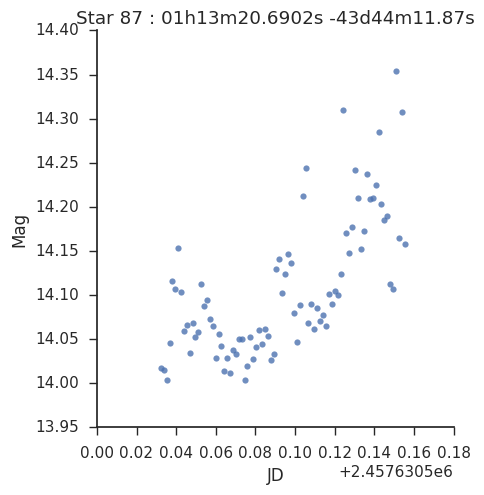

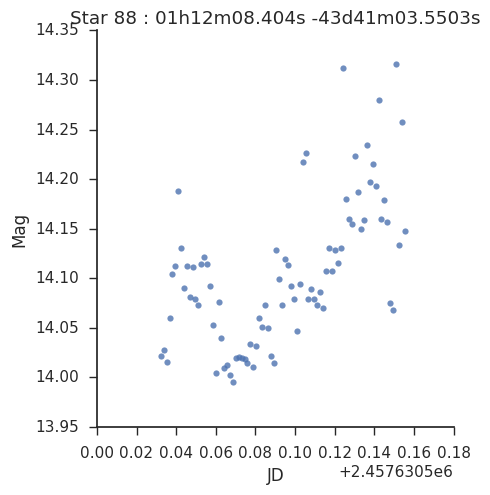

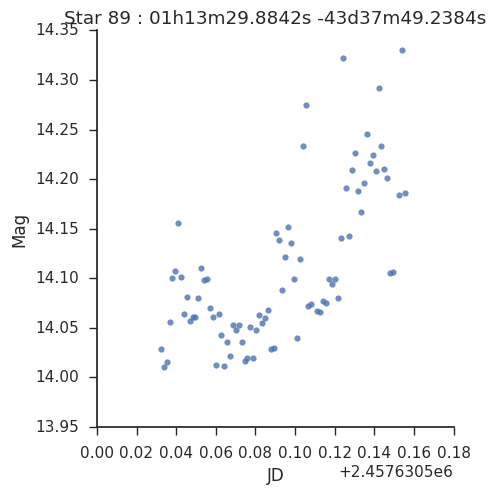

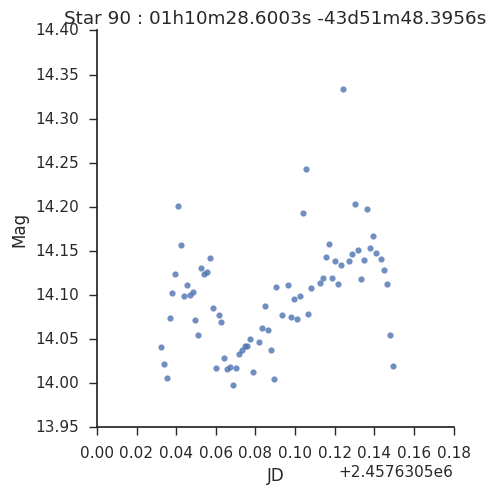

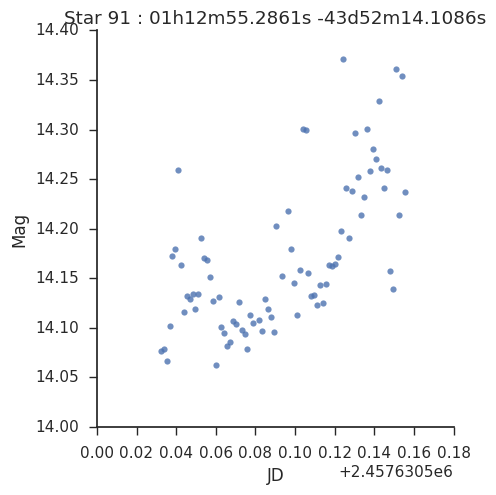

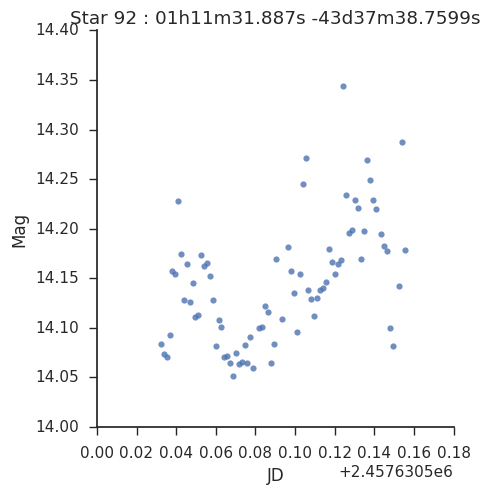

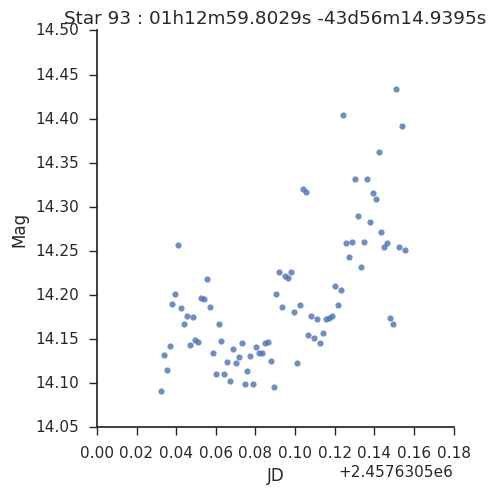

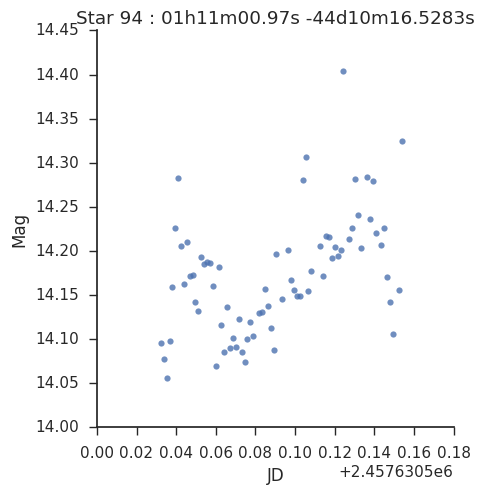

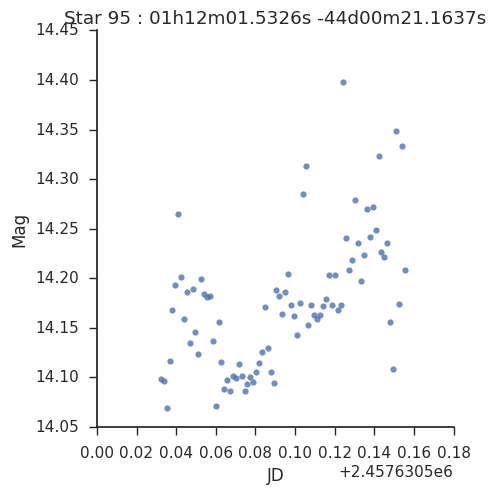

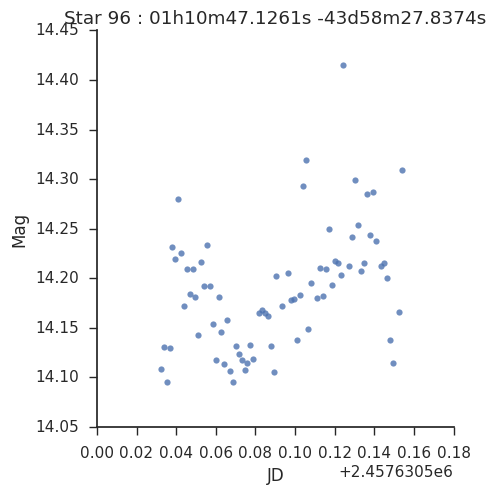

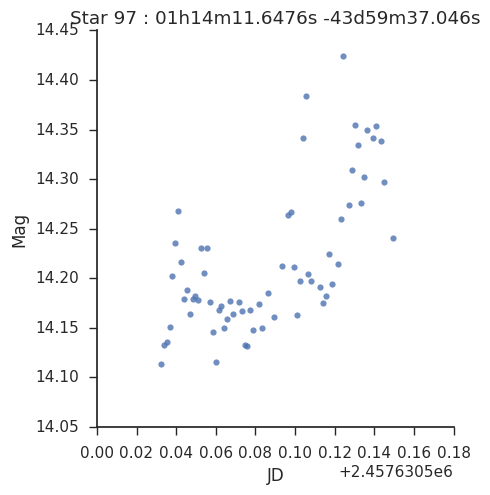

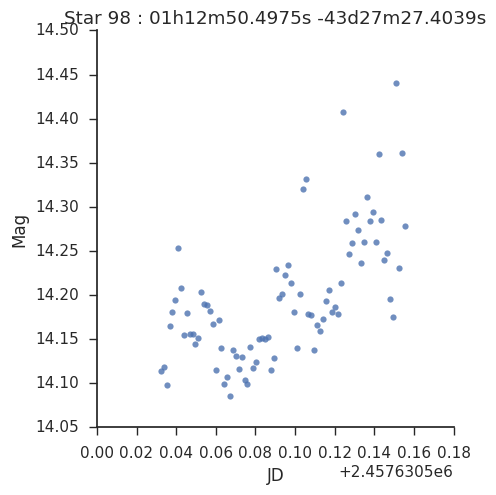

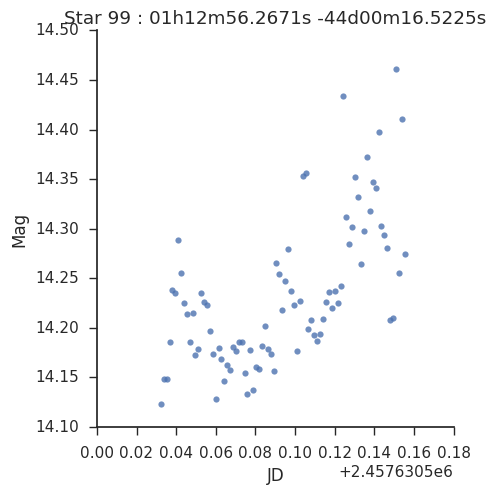

In [54]:
def set_seaborn_style():
    sns.set_context("notebook", font_scale=1.1)
    sns.set_style("ticks")

def read_lightcurve(star):
    df = pd.read_csv(lightcurve_dir + str(star) + '.txt', skiprows=[1], sep=' ')
    df = df[df['V-C'] < 99]
    return df

def read_pos(star):
    df = pd.read_csv(lightcurve_dir + 'pos_' + str(star) + '.txt', skiprows=[1], sep=' ')
    return (df['X'][0], df['Y'][0])

def plot_lightcurve(df2, pos, name):
    g = sns.lmplot('JD', 'V', 
               data=df2, 
               fit_reg=False)
    plt.title('Star '+ str(name) + " : " + pixel_to_radec(wcs_config, pos[0], pos[1]).to_string('hmsdms'))
    plt.xlabel('JD')
    plt.ylabel('Mag')    
    sns.plt.show()
    g.savefig(lightcurve_dir+str(star))
    
set_seaborn_style()
for star in star_list:
    plot_lightcurve(read_lightcurve(star), read_pos(star), star)


In [34]:
from sklearn import preprocessing
df2_f = df2.loc[df['V-C'] < 90] 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df2_f['JD'])
fig = plt.figure()
ax = fig.add_subplot(111)
x = x_scaled
y = df2_f['V-C']
ax.plot(x, y, '.')


KeyError: 'V-C'

In [ ]:
print(__doc__)

from sklearn.ensemble import IsolationForest

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()